# 6.1 RNN의 문제점

## 6.1.3 기울기 소실과 기울기 폭발의 원인

In [2]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)
norm_list = []

for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)    

print(norm_list)

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


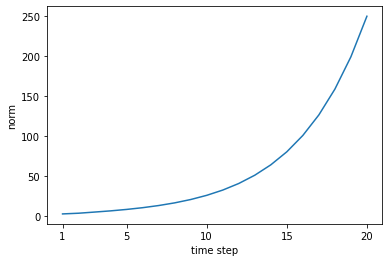

In [4]:
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]


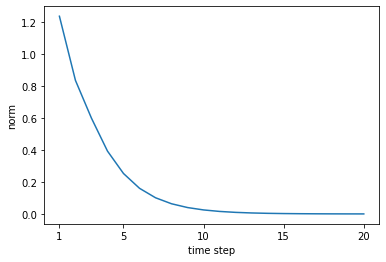

In [5]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5
norm_list = []

for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)    

print(norm_list)

plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

## 6.1.4 기울기 폭발 대책

기울기 클리핑의 구현

In [7]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grads ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

# 6.3 LSTM 구현

LSTM 계층 구현

In [9]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

## 6.3.1 Time LSTM 구현

In [10]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtpye='f')
        
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None

# 6.4 LSTM을 사용한 언어 모델

In [11]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

PTB 데이터셋 학습

Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 10001.07
| 에폭 1 |  반복 21 / 1327 | 시간 5[s] | 퍼플렉서티 2774.96
| 에폭 1 |  반복 41 / 1327 | 시간 11[s] | 퍼플렉서티 1206.40
| 에폭 1 |  반복 61 / 1327 | 시간 17[s] | 퍼플렉서티 946.03
| 에폭 1 |  반복 81 / 1327 | 시간 23[s] | 퍼플렉서티 797.80
| 에폭 1 |  반복 101 / 1327 | 시간 28[s] | 퍼플렉서티 656.92
| 에폭 1 |  반복 121 / 1327 | 시간 34[s] | 퍼플렉서티 634.66
| 에폭 1 |  반복 141 / 1327 | 시간 40[s] | 퍼플렉서티 600.35
| 에폭 1 |  반복 161 / 1327 | 시간 46[s] | 퍼플렉서티 573.38
| 에폭 1 |  반복 181 / 1327 | 시간 52[s] | 퍼플렉서티 583.34
| 에폭 1 |  반복 201 / 1327 | 시간 58[s] | 퍼플렉서티 492.37
| 에폭 1 |  반복 221 / 1327 | 시간 64[s] | 퍼플렉서티 481.59
| 에폭 1 |  반복 241 / 1327 | 시간 70[s] | 퍼플렉서티 439.39
| 에폭 1 |  반복 261 / 1327 | 시간 77[s] | 퍼플렉서티 458.79
| 에폭 1 |  반복 281 / 1327 | 시간 83[s] | 퍼플렉서티 452.77
| 에폭 1 |  반복 301 / 1327 | 시간 90[s] | 퍼플렉서티 387.78
| 에폭 1 |  반복 321 / 1327 | 시간 97[s] | 퍼플렉서티 343.34
| 에폭 1 |  반복 341 / 1327 | 시간 104[s] | 퍼플렉서티 392.69
| 에폭 1 |  반복 361 / 1327 | 시간 111[s] | 퍼플렉서티 399.84
| 에폭 1 |  반복 381 / 1327 | 시간 118[s] | 퍼플렉서티 329

| 에폭 3 |  반복 521 / 1327 | 시간 1066[s] | 퍼플렉서티 137.74
| 에폭 3 |  반복 541 / 1327 | 시간 1073[s] | 퍼플렉서티 136.35
| 에폭 3 |  반복 561 / 1327 | 시간 1080[s] | 퍼플렉서티 118.63
| 에폭 3 |  반복 581 / 1327 | 시간 1086[s] | 퍼플렉서티 105.49
| 에폭 3 |  반복 601 / 1327 | 시간 1093[s] | 퍼플렉서티 147.47
| 에폭 3 |  반복 621 / 1327 | 시간 1099[s] | 퍼플렉서티 143.03
| 에폭 3 |  반복 641 / 1327 | 시간 1105[s] | 퍼플렉서티 129.56
| 에폭 3 |  반복 661 / 1327 | 시간 1112[s] | 퍼플렉서티 121.06
| 에폭 3 |  반복 681 / 1327 | 시간 1118[s] | 퍼플렉서티 100.10
| 에폭 3 |  반복 701 / 1327 | 시간 1125[s] | 퍼플렉서티 119.04
| 에폭 3 |  반복 721 / 1327 | 시간 1132[s] | 퍼플렉서티 126.76
| 에폭 3 |  반복 741 / 1327 | 시간 1139[s] | 퍼플렉서티 106.54
| 에폭 3 |  반복 761 / 1327 | 시간 1146[s] | 퍼플렉서티 103.75
| 에폭 3 |  반복 781 / 1327 | 시간 1153[s] | 퍼플렉서티 104.56
| 에폭 3 |  반복 801 / 1327 | 시간 1161[s] | 퍼플렉서티 115.80
| 에폭 3 |  반복 821 / 1327 | 시간 1169[s] | 퍼플렉서티 116.65
| 에폭 3 |  반복 841 / 1327 | 시간 1176[s] | 퍼플렉서티 114.14
| 에폭 3 |  반복 861 / 1327 | 시간 1183[s] | 퍼플렉서티 121.51
| 에폭 3 |  반복 881 / 1327 | 시간 1190[s] | 퍼플렉서티 106.85
| 에폭 3 |  반복

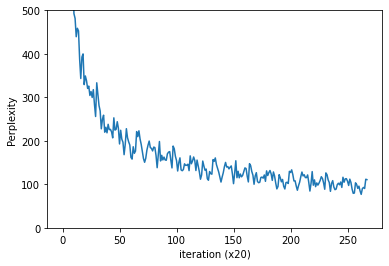

퍼플렉서티 평가 중 ...
234 / 235
test perplexity: 135.6627894363685


In [12]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 1. 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
           eval_interval=20)
trainer.plot(ylim=(0, 500))

# 2. 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity:', ppl_test)

# 3. 매개변수 저장
model.save_params()

# 6.5 RNNLM 추가 개선

## 6.5.4 개선된 RNNLM 구현

In [ ]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650,
                hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 세 가지 개선
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 가중치 공유
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(score, ts)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

In [ ]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
               time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('val perplexity:', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
    
    model.reset_state()
    print('-' * 50)